Mounted at /content/drive
Total images loaded: 3504
Train images: 2803, Test images: 701
Total images loaded: 3504
Train images: 2803, Test images: 701


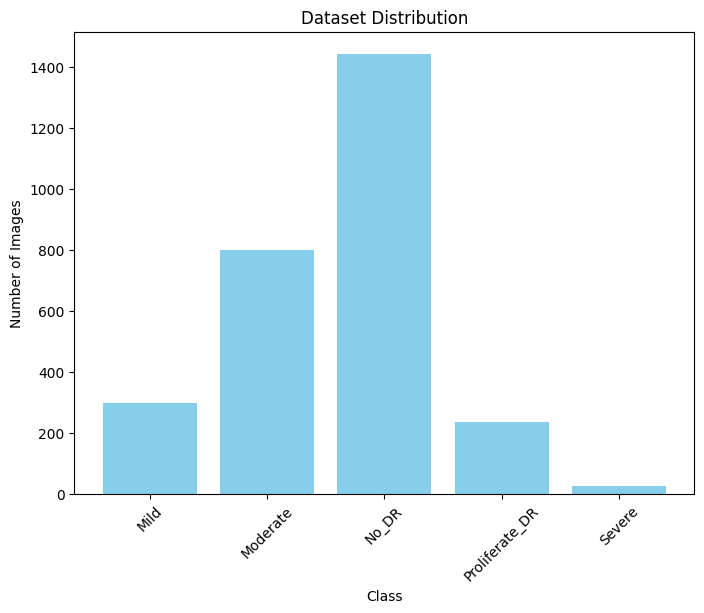

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 189MB/s]


Epoch 1/40, Loss: 1.2993, Training Accuracy: 0.5391
Epoch 2/40, Loss: 0.8615, Training Accuracy: 0.7003
Epoch 3/40, Loss: 0.7357, Training Accuracy: 0.7406
Epoch 4/40, Loss: 0.6839, Training Accuracy: 0.7574
Epoch 5/40, Loss: 0.6290, Training Accuracy: 0.7720
Epoch 6/40, Loss: 0.6140, Training Accuracy: 0.7756
Epoch 7/40, Loss: 0.5867, Training Accuracy: 0.7806
Epoch 8/40, Loss: 0.5665, Training Accuracy: 0.7884
Epoch 9/40, Loss: 0.5492, Training Accuracy: 0.7941
Epoch 10/40, Loss: 0.5383, Training Accuracy: 0.8016
Epoch 11/40, Loss: 0.5317, Training Accuracy: 0.7977
Epoch 12/40, Loss: 0.5060, Training Accuracy: 0.8106
Epoch 13/40, Loss: 0.5109, Training Accuracy: 0.8195
Epoch 14/40, Loss: 0.4970, Training Accuracy: 0.8120
Epoch 15/40, Loss: 0.4852, Training Accuracy: 0.8213
Epoch 16/40, Loss: 0.4705, Training Accuracy: 0.8248
Epoch 17/40, Loss: 0.4491, Training Accuracy: 0.8387
Epoch 18/40, Loss: 0.4607, Training Accuracy: 0.8288
Epoch 19/40, Loss: 0.4702, Training Accuracy: 0.8248
Ep

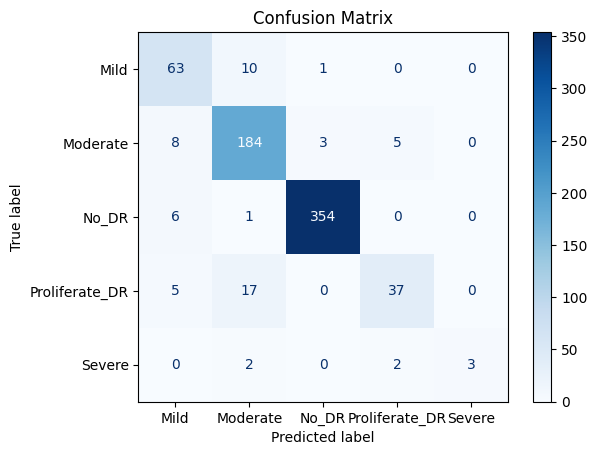

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from google.colab import drive
from PIL import Image

# Mount Google Drive
drive.mount('/content/drive')

# Paths
data_dir = '/content/drive/My Drive/colored_images'
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

# Dataset class
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, data_dir, transform=None, split='train'):
        self.data_dir = data_dir
        self.transform = transform
        self.split = split
        self.image_paths = []
        self.labels = []

        # Collect all image paths and labels
        for idx, class_name in enumerate(class_names):
            class_dir = os.path.join(data_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if img_name.lower().endswith(('png', 'jpg', 'jpeg')):
                        self.image_paths.append(img_path)
                        self.labels.append(idx)
            else:
                print(f"Warning: {class_dir} does not exist.")
        print(f"Total images loaded: {len(self.image_paths)}")

        # Split the dataset into training and testing
        train_paths, test_paths, train_labels, test_labels = train_test_split(
            self.image_paths, self.labels, test_size=0.2, stratify=self.labels
        )
        print(f"Train images: {len(train_paths)}, Test images: {len(test_paths)}")

        self.image_paths = train_paths if split == 'train' else test_paths
        self.labels = train_labels if split == 'train' else test_labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# DataLoaders
train_dataset = DiabeticRetinopathyDataset(data_dir, transform=transform, split='train')
test_dataset = DiabeticRetinopathyDataset(data_dir, transform=transform, split='test')

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Dataset distribution visualization
class_counts = {class_name: 0 for class_name in class_names}
for label in train_dataset.labels:
    class_counts[class_names[label]] += 1

plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution')
plt.xticks(rotation=45)
plt.show()

# Model setup for EfficientNetB4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.efficientnet_b4(weights='EfficientNet_B4_Weights.IMAGENET1K_V1')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Training loop with accuracy calculation
epochs = 40
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_dataloader):.4f}, Training Accuracy: {train_accuracy:.4f}')

# Save model
torch.save(model.state_dict(), '/content/drive/My Drive/Diabetic_Retinopathy_Model_B4.pth')

# Evaluation (on test dataset)
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
acc = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f'Test Accuracy: {acc:.4f}, Kappa Score: {kappa:.4f}')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Saving fc4c2d35c6f8.png to fc4c2d35c6f8.png


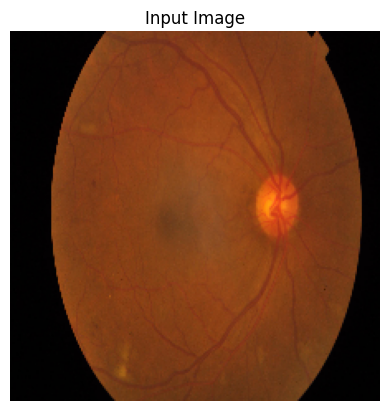

Predicted Class: Moderate (96.87%)


In [ ]:
# Prediction of image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

# Define class names
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.efficientnet_b4(weights='EfficientNet_B4_Weights.IMAGENET1K_V1')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
model.load_state_dict(torch.load('/content/drive/My Drive/Diabetic_Retinopathy_Model_B4.pth', map_location=device))
model = model.to(device)
model.eval()

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to predict class of an image
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)  # Show the input image
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]  # Convert logits to probabilities
        predicted_class = torch.argmax(probabilities).item()
        confidence = probabilities[predicted_class].item() * 100  # Convert to percentage

    print(f"Predicted Class: {class_names[predicted_class]} ({confidence:.2f}%)")

# Upload and classify an image
from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    predict_image(filename)
